In [49]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from scipy.stats import linregress
from scipy import stats
from scipy.special import erfinv, erf

In [2]:
%ls data/recall_scores/panic_fine44_*

data/recall_scores/panic_fine44_a1.pkl
data/recall_scores/panic_fine44_a2.pkl
data/recall_scores/panic_fine44_a3.pkl
data/recall_scores/panic_fine44_prompt0_gpt-4-0613_set1.pkl


### Human scores 

human scores are stored in separate files each file represent a pandas data series, each entry consisted of list of recalled clauses.

In [3]:
# reading human evaluation of the recalls
human_scores = {}
for k in range(1,4):
      human_scores[k]= pd.read_pickle( f'data/recall_scores/panic_fine44_a{k}.pkl')
#reading evaluated story segmentation
panic_segmentation=pd.read_pickle('data/recall_scores/panic_segmentation.pkl')['fine44']
# reading GPT-4 scores
gpt_scores = pd.read_pickle("data/recall_scores/panic_fine44_prompt0_gpt-4-0613_set1.pkl")

# Recall Analysis


For recall, we construct a hit matrix. Let us denote this by $h^{\mu}_{i}$. We have that

$h_{i}^{\mu} = 1$ if subject $\mu$ recalled clause $i$. Otherwise, $h_{i}^{\mu} = 0$. From this matrix, we can construct

- Recall Probability
\begin{equation}
r_{i} = \frac{1}{N}\sum_{\mu = 1}^{N} h_{i}^{\mu}
\end{equation}

- Total Items Recalled
 \begin{equation}
 \langle R \rangle = \sum_{i} r_{i} = \frac{1}{N} \sum_{\mu} R^{\mu} = \frac{1}{N} \sum_{i, \mu} h_{i}^{\mu}
 \end{equation}

where $R^{\mu} = \sum_{i =1}^{L} h_{i}^{\mu}$


- Variance of Recall

The second moment is
\begin{equation}
m_{2,R} = \frac{1}{N} \sum_{\mu} \left(R^{\mu}\right)^{2} = \frac{1}{N} \sum_{\mu} \sum_{i, i'} h_{i}^{\mu} h_{i'}^{\mu}
\end{equation}

The variance is

\begin{align}
v_{R} = m_{2,R} - m_{1,R}^{2}
\end{align}

In [4]:
# This function computes the hit matrix
def get_hit_matrix(scores, segmentation):
    Ss = len(scores)
    total_seg_long = len(segmentation.split('\n'))
    hit_matrix = np.zeros((Ss,total_seg_long))
    for k,r in enumerate(scores):
        if r!=[]:
            hit_matrix[k,np.array(r)-1] = 1
    return hit_matrix


In [5]:
panic_segmentation_split= panic_segmentation.split('\n')
total_seg = len(panic_segmentation_split)
seg_length = total_seg #len(segmentation.split('\n'))

human_hit= {}
for k in range(1,4):
    human_hit[k] = get_hit_matrix(human_scores[k],panic_segmentation)

human_data = np.vstack([h.mean(axis=0) for h in human_hit.values()])

human_hit_mean = np.mean(human_data,axis=0)
human_hit_std= np.std(human_data,axis=0)
human_hit_min = np.min(human_data,axis = 0)
human_hit_max = np.max(human_data,axis = 0)

gpt_hit_1 = get_hit_matrix(gpt_scores,panic_segmentation) 

# Reliability of GPT-4 scoring recall (Figure 1)
 
Here we compare evaluation of recalls by humans and by GPT-4

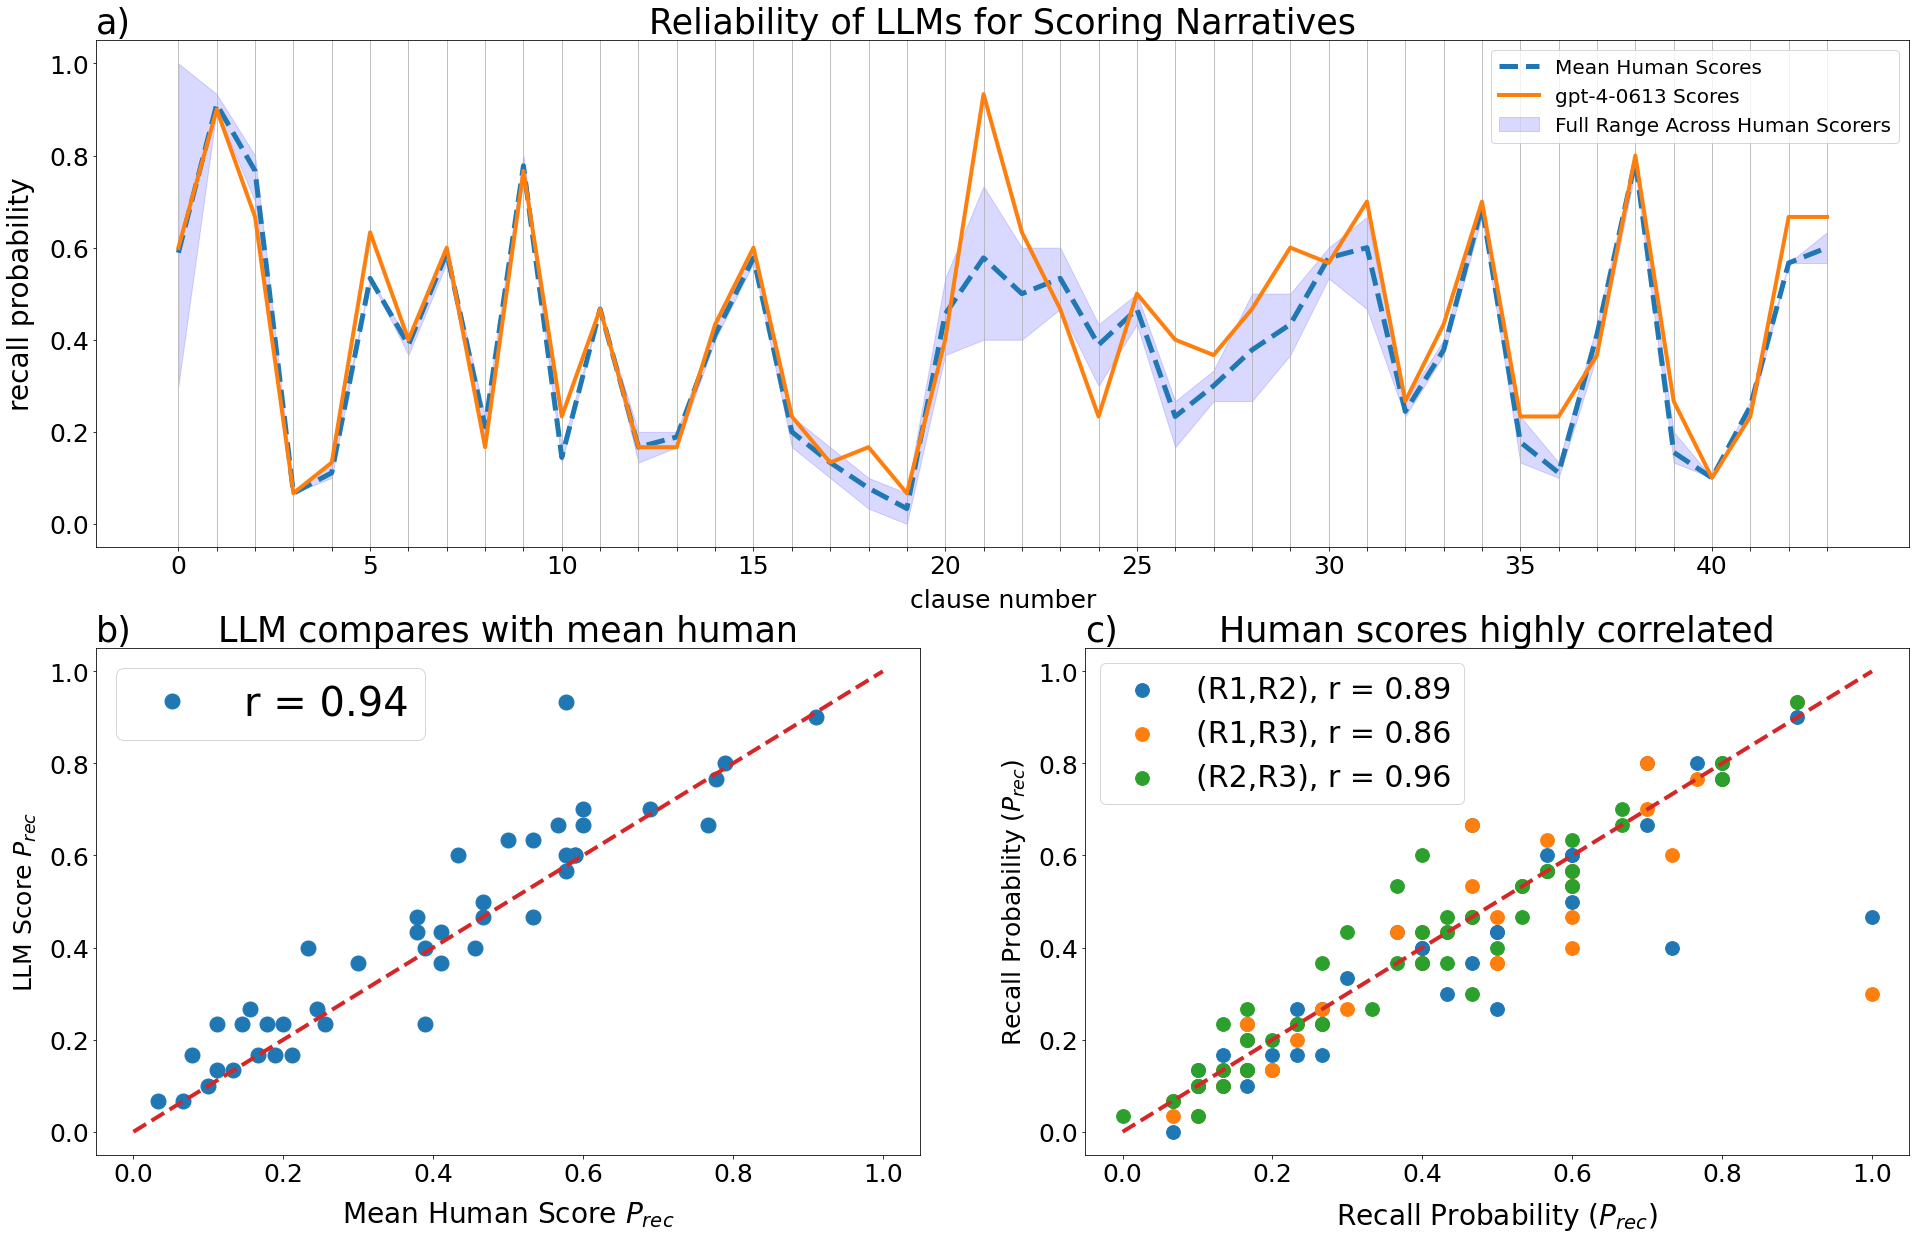

In [6]:
fig = plt.figure(figsize=(32.5, 20.5))  #, layout="constrained"
spec = fig.add_gridspec(2, 2)

ax0 = fig.add_subplot(spec[0, :])

ax = plt.gca()
ax0.set_xticks(np.arange(seg_length))


temp = ax.xaxis.get_ticklabels()
temp = list(set(temp) - set(temp[::5]))
for label in temp:
    label.set_visible(False)


#ax.set_xticks(2*np.arange(1,int((seg_length+1)/2)))
#ax.set_xticklabels(2*np.arange(1,int((seg_length+1)/2)))
#ax.set_xticklabels(np.arange(1,seg_length+1)) # range of values in edges

#ax0.set_xticks(fontsize=14)
#ax0.set_yticks(fontsize=14)

ax0.tick_params(axis='both', which='major', labelsize=25)

ax0.plot(np.arange(1,seg_length+1)-1,human_hit_mean,'--',linewidth = 5,label = 'Mean Human Scores',color='tab:blue')
ax0.fill_between(np.arange(1,seg_length+1)-1,human_hit_min, human_hit_max, color='b', alpha=.15,label = 'Full Range Across Human Scorers')

ax0.plot(np.arange(1,seg_length+1)-1,gpt_hit_1.mean(axis=0),'-',markersize = 12,linewidth = 4,label='gpt-4-0613 Scores',color='tab:orange')


ax0.set_ylabel('recall probability',labelpad = 14,fontsize = 28)
ax0.set_xlabel('clause number', labelpad = 10,fontsize = 25)

ax0.xaxis.grid(True)
#plt.savefig('reliability_plot.png')
ax0.legend(fontsize= 20)



ax10 = fig.add_subplot(spec[1, 0])
#annotate_axes(ax10, 'ax10')
rval = np.round(np.corrcoef(gpt_hit_1.mean(axis = 0),human_hit_mean.T)[0,1],2)
ax10.plot(human_hit_mean,gpt_hit_1.mean(axis = 0),'o',markersize = 15,label = 'r = '+str(rval))
#ax10.scatter(human_hit_mean,gpt_hit_chat.mean(axis = 0),s = 70,label = 'r = '+str(rval))
#ax10.scatter(human_hit_mean,gpt_hit_3.mean(axis = 0),s = 70,label = 'r = '+str(rval))
ax10.plot([0,1],[0,1],'--' ,linewidth = 4,color = 'tab:red')
ax10.tick_params(axis='both', which='major', labelsize=25)
ax10.set_xlabel('Mean Human Score $P_{rec}$',labelpad = 14,fontsize = 28)
ax10.set_ylabel('LLM Score $P_{rec}$', labelpad = 10,fontsize = 25)

ax10.legend(fontsize = 40)


r_human = np.corrcoef(human_data)

rval01 = np.round(r_human[0,1],2)
rval02 = np.round(r_human[0,2],2)
rval12 = np.round(r_human[1,2],2)
ax11 = fig.add_subplot(spec[1, 1])

#ax11.scatter(gpt_hit_1.mean(axis = 0),gpt_hit_3.mean(axis = 0),s = 190,label = 'r = '+str(rval))

ax11.scatter(human_data[0],human_data[1],s = 190,label = '(R1,R2), r = '+str(rval01))
ax11.scatter(human_data[0],human_data[2],s = 190,label = '(R1,R3), r = '+str(rval02))
ax11.scatter(human_data[1],human_data[2],s = 190,label = '(R2,R3), r = '+str(rval12))
#ax10.scatter(human_hit_mean,gpt_hit_3.mean(axis = 0),s = 70,label = 'r = '+str(rval))
ax11.plot([0,1],[0,1],'--' ,linewidth = 4,color = 'tab:red')


ax11.tick_params(axis='both', which='major', labelsize=25)
ax11.set_xlabel('Recall Probability ($P_{rec}$)',labelpad = 14,fontsize = 28)

ax11.set_ylabel('Recall Probability ($P_{rec}$)', labelpad = 10,fontsize = 25)


ax0.set_title('a)', loc = 'left',fontsize = 35)
ax10.set_title('b)', loc = 'left',fontsize = 35)
ax11.set_title('c)', loc = 'left',fontsize = 35)

ax11.legend(fontsize = 30)
#annotate_axes(ax11, 'ax11')

ax0.set_title('Reliability of LLMs for Scoring Narratives',fontsize = 35)
ax10.set_title('LLM compares with mean human',fontsize = 35)
ax11.set_title('Human scores highly correlated',fontsize = 35)

#plt.savefig('figure-reliability.png')
plt.show()



# Scaling law in narrative recall (Figure 2)

# Recognition Analysis

Below are two functions which are used to compute the mean $\langle M\rangle$ and the variance via bootstrap. First, to set up notation, the recognition data for each participant is ${\bf x}^{\mu}(t) \in \{-1,0,1\}^{2L}$, where the $2L$ vector encodes the outcome of the recognition experiment for trial $t$, in the following way. 

For a given story with $L$ clauses, the pool of subjects is exposed to $L$ lures. We index the clauses $i = 1, ..., L$, and the lures $i = L+1, ..., 2L$. In a given trial, we denote the sequence of clauses/lures as $i_{t}$ for $t = 1, ...,S$. 

The outcome of a trial will take one of the following values:

- $o^{+}$: true positive, or equivalently 'hit'
-  $o^{-}$: true negative, or a 'miss'
- $l^{+}$: false positive, or a 'false alarm'
- $l^{-}$: false negative, or a 'correct rejection'

We can encode this in our vector encoding of the outcome in the following way. Let $o^{+} = l^{+}  =  1$ and $o^{-}= l^{-}  =  -1$. Then let $X^{\mu}(t)$ encode this value for each outcome. In other words, $X^{\mu}(t)$ only records whether the subjects says 'Yes' or 'No'. Then


$x_{i}^{\mu}(t) = \delta_{i i_{t}} X^{\mu}(t)$


"recog_hit_matrix" computes precisely this third-order tensor $x_{i}^{\mu}(t)$. 



From this representation, we can extract some useful quantities. 


 - pTPR (Population True Positive Rate): We obtain this from the formula (note the summation over $i$ is restricted to values $\le L$)
 \begin{equation}
 pTPR(L) = \frac{1}{2} \frac{\sum_{\mu,t} \sum_{i = 1}^{L} \left( x_{i}^{\mu}(t) + | x_{i}^{\mu}(t)| \right)}{\sum_{\mu, t}\sum_{i=1}^{L} | x_{i}^{\mu}(t)|}
 \end{equation}

The reason is that $\sum_{\mu, t} \sum_{i = 1}^{L} x_{i}^{\mu}(t) = H - M$, where $H$ is the total hits and $M$ is the total misses. Whereas $\sum_{\mu, t} \sum_{i = 1}^{L} |x_{i}^{\mu}(t)| = H + M$. This quantity is therefore equivalent to $H/(H+M)$. 

 - pFPR (Population False Positive Rate): We obtain this from the formula
 \begin{equation}
 pFPR(L) = \frac{1}{2} \frac{\sum_{\mu, t} \sum_{i = L+1}^{2L} \left( x_{i}^{\mu}(t) + | x_{i}^{\mu}(t)| \right)}{\sum_{\mu, t}\sum_{i=L+1}^{2L} | x_{i}^{\mu}(t)|}
 \end{equation}

Notice that the only difference here is the summation of $i$ goes from $L+1$ to $2L$. This quantity therefore is equavalent to $FA/(FA + CR)$

- Recognition Probability 
\begin{align}
 m_{i} = \frac{1}{2} \frac{\sum_{\mu, t}  \left( x_{i}^{\mu}(t) + | x_{i}^{\mu}(t)| \right)}{\sum_{\mu, t} | x_{i}^{\mu}(t)|}
\end{align}

This is computed by keeping the clause fixed, and computing the $H_{i}/(H_{i} + M_{i})$ for a given clause $i$. 


The estimate for the total number of clauses encoded is given by the formula

\begin{align}
\langle M \rangle = L \frac{\Big(pTPR - pFPR \Big)}{1 - pFPR}
\end{align}



{\bf Proof of formula for M}:


We calculate the probability of of a hit:


\begin{align}
P(hit) = P(yes|m \in M)P(m \in M) + P(yes| m \notin M) P(m \notin M)\\
P(hit) = M/L + P(fa) (1 - M/L) = P(fa) + (1- P(fa)) M/L
\end{align}
So that

\begin{align}
 M = \frac{L}{1-P(fa)} \left( P(hit) - P(fa)\right)
\end{align}




In [26]:
# this function lists all the files in the dataset folder

def files_in_folder(folder, ext):
    files_datasets = []
    for fname in os.listdir(os.path.join('data/', folder)):
        if not fname.endswith(ext):
            continue
        yield fname

#This function constructs the basic third-order tensor which encapsulates the recognition data

def recog_hit_matrix(dataset):
    segmentation = dataset['segmentation']
    seg_list = segmentation.split('\n')
    lure_list = list(dataset['lures'].values)
    clause_pool = seg_list + lure_list
    L = len(seg_list)
    recog_data = dataset['recognition']
    pop = len(recog_data)
    T = len(recog_data[0])
    id_len = len(clause_pool)
    recog_arr = np.zeros((pop,id_len,T))

    recog_data_num = []

    for p in range(pop):
        T = len(recog_data[p])
        r_p = []
        for t in range(T):
            rdvec = recog_data[p][t]
            outcome = rdvec['value'] 
            idx = rdvec['id']
            if idx < id_len:
                if outcome == 'hit' or outcome == 'fa':
                    bin_outcome = 1.;
                    r_p +=[[idx,1]];
                else:
                    bin_outcome = -1.;
                    r_p +=[[idx,0]]

                recog_arr[p,idx,t] = bin_outcome
    
    return recog_arr


#############################################
# These are very similar functions, just with different arguments


#This funcion depends on T, and does not 
def recog_prob(recog_arr,T):
    L = int(recog_arr.shape[1]/2)
    dh = recog_arr[:,:L,:T].sum(axis = 2).sum(axis = 0)    # Sum over Trial and Population
    tot = abs(recog_arr[:,:L,:T]).sum(axis = 2).sum(axis = 0)
    
    dh_lure = recog_arr[:,L:,:T].sum(axis = 2).sum(axis = 0)
    tot_lure = abs(recog_arr[:,L:,:T]).sum(axis = 2).sum(axis = 0)
    
    return  .5*(dh + tot)/tot, .5*(dh_lure + tot_lure)/tot_lure

def recog_prob_dist(dataset):     #takes only dataset as input
    r_mat = recog_hit_matrix(dataset)
    T = r_mat.shape[2]
    hr, far = recog_prob(r_mat,T)
    
    #L = int(r_mat.shape[1]/2)
    #rdiff = r_mat[:,:L,:].sum(axis=2).sum(axis=0)     #sum over ALL trials and Population
    #rsum = abs(r_mat[:,:L,:]).sum(axis=2).sum(axis=0)
    #r_prob = .5*(rdiff+rsum)/rsum
    return hr,far






#############################################

#This leaves T, total number of trials, an adjustable argument to compute the population averaged M

def mean_recog(recog_arr,T):
    L = int(recog_arr.shape[1]/2)
    dh = recog_arr[:,:L,:T].sum()
    tot = abs(recog_arr[:,:L,:T]).sum()
    tpr = .5*(dh + tot)/tot
    
    dh_lure = recog_arr[:,L:,:T].sum()
    tot_lure = abs(recog_arr[:,L:,:T]).sum()
    far = .5*(dh_lure + tot_lure)/tot_lure
    
    
    
    return  L*(tpr + far)/(1 - far) #L*(1 - 2*(1 - tpr))
    

    
def tpr_time(recog_arr):
    L = int(recog_arr.shape[1]/2)
    dh = recog_arr[:,:L,:].sum(axis=0).sum(axis = 0)
    tot = abs(recog_arr[:,:L,:]).sum(axis=0).sum(axis = 0)
    tpr = .5*(dh + tot)/tot
    
    
    return  L, tpr




        #This computes the mean and standard deviation of the population vector
def R_stats(dataset):
    recall_data = dataset['recall scores']
    segmentation = dataset['segmentation'] 
    recall_hits = get_hit_matrix(recall_data,segmentation)
    R_pop = recall_hits.sum(axis = 1)
    #N_pop = recall_hits.shape[0]
    #R_mean = recall_hits.sum()/N_pop
    #R_var = np.matmul(recall_hits.T,recall_hits).sum()/N_pop - R_mean**2
    return R_pop.mean(), R_pop.std()


def M_probs(dataset,sample_frac):
    r_mat = recog_hit_matrix(dataset)
    P,LL,T = r_mat.shape       #P = population, LL = 2*story_length, T = trials
    L = int(LL/2)
    r_mat = r_mat.swapaxes(0,1)
    r_mat = r_mat.reshape(LL,P*T)
    sample = int(sample_frac*P*T)
    subset = np.random.choice(range(P*T),sample)   #use to be random.sample
    subset2 = np.random.choice(range(P*T),sample)
    
    r_boot_old = r_mat[:L,subset]
    r_boot_new = r_mat[L:,subset2]
    
    rdiff_old = r_boot_old.sum();
    
    rdiff_new = r_boot_new.sum()
    
    
    rsum_old = abs(r_boot_old).sum()
    hits= .5*(rdiff_old + rsum_old)
    hit_miss = rsum_old
    TPR = hits/hit_miss
    
    rsum_new = abs(r_boot_new).sum()
    fa= .5*(rdiff_new + rsum_new)
    fa_cr = rsum_new
    FAR = fa/fa_cr
    
    return TPR, FAR

#Compute M from the population

def M_sample(dataset,sample_frac):
    r_mat = recog_hit_matrix(dataset)
    P,LL,T = r_mat.shape       #P = population, LL = 2*story_length, T = trials
    L = int(LL/2)
    r_mat = r_mat.swapaxes(0,1)
    r_mat = r_mat.reshape(LL,P*T)
    sample = int(sample_frac*P*T)
    subset = np.random.choice(range(P*T),sample)
    subset2 = np.random.choice(range(P*T),sample)
    
    r_boot_old = r_mat[:L,subset]
    r_boot_new = r_mat[L:,subset2]
    
    rdiff_old = r_boot_old.sum();
    
    rdiff_new = r_boot_new.sum()
    
    
    rsum_old = abs(r_boot_old).sum()
    hits= .5*(rdiff_old + rsum_old)
    hit_miss = rsum_old
    TPR = hits/hit_miss
    
    rsum_new = abs(r_boot_new).sum()
    fa= .5*(rdiff_new + rsum_new)
    fa_cr = rsum_new
    FAR = fa/fa_cr
    
    return L*(TPR - FAR)/(1 - FAR)



# collect many bootstrap samples
def M_stats(dataset,sample_frac,samples):
    m_samp = []
    for i in range(samples):
        m_samp += [M_sample(dataset,sample_frac)]
    
    return np.array(m_samp)


In [28]:
# Set bootstrap parameters for estimating errors of M
sample_frac = 1.;   #sets fraction of dataset to sample from, used 0.2 before
samples = 2000;  #how many samples to collect for bootstrap, used 500 before

Rm = []
R_err = []
Mm = []
M_err = []
Lx = []

story_name = []

tpr_x = []
far_x = []

for f in files_in_folder('compiled_data', '.pkl'):
    if f not in ['ghosts.pkl']:        #f!='ghosts' and f!='hester_v2-church-scrambled':
        print('     ', f)
        fn = 'data/compiled_data/' + f
        dataset = pd.read_pickle(fn)
        Lx +=[len(dataset['segmentation'].split('\n'))]
        
        r_mean,r_std = R_stats(dataset)
        
        mt_pop = M_stats(dataset,sample_frac,samples)
        
        tpr, far = M_probs(dataset,1.)
        
        tpr_x +=[tpr]
        far_x +=[far]
        
        n = len(dataset['recall scores'])
        Rm +=[r_mean]
        R_err +=[r_std/np.sqrt(n)]

        Mm +=[mt_pop.mean()]
        M_err+=[np.std(mt_pop,ddof=1)]

        story_name +=[f]


      schissel_v1-pool.pkl
      triplett_v1-rookie.pkl
      hester_v2-church.pkl
      triplett_v2-catlady.pkl
      panic.pkl
      boyscout-scrambled.pkl
      schissel_v2-lake.pkl
      triplett_v1-rookie-scrambled.pkl
      hester_v2-church-scrambled.pkl
      boyscout.pkl
      biker.pkl
      stein-scrambled.pkl
      hester_v1-park.pkl
      stein.pkl


In [42]:
#these stories are excluded for fitting purposes

exclude_set = ['panic','biker','hester_v2-church-scrambled','boyscout-scrambled','triplett_v1-rookie-scrambled','stein-scrambled']


#these the scrambled stories
scram_set = ['hester_v2-church-scrambled','boyscout-scrambled','triplett_v1-rookie-scrambled','stein-scrambled']

arg_include = [] 
arg_exclude = []
for i in range(len(story_name)):
    s = story_name[i][:-4]
    if s not in exclude_set:
        arg_include +=[i]
    
    elif s in scram_set:
        arg_exclude +=[i]

arg_include = np.array(arg_include)

arg_exclude = np.array(arg_exclude)

In [43]:
rt = np.array(Rm)[arg_include]
mt = np.array(Mm)[arg_include]
lt = np.array(Lx)[arg_include]
rt_error = np.array(R_err)[arg_include]
mt_error = np.array(M_err)[arg_include]


TPR= np.array(tpr_x)[arg_include]
FAR = np.array(far_x)[arg_include]
rt_sc = np.array(Rm)[arg_exclude]
mt_sc = np.array(Mm)[arg_exclude]
lt_sc = np.array(Lx)[arg_exclude]
rt_error_sc = np.array(R_err)[arg_exclude]
mt_error_sc = np.array(M_err)[arg_exclude]

TPR_sc = np.array(tpr_x)[arg_exclude]
FAR_sc = np.array(far_x)[arg_exclude]

In [51]:
#fitting the slope

rm_regress =linregress(mt,rt)


rl_regress = linregress(lt[:],rt[:])

ml_regress = linregress(lt[:],mt[:])



rm_regress_log =linregress(np.log(mt),rt)


r_r, pval_r = stats.pearsonr(lt, rt)
r_m,pval_m = stats.pearsonr(lt, mt)


    
r_mr,pval_mr = stats.pearsonr(mt, rt)

r_m,pval_m = stats.pearsonr(lt, mt)
r_mr,pval_mr = stats.pearsonr(mt, rt)


x = np.array(lt)
y = np.array(rt)
x = x[:,np.newaxis]
aR, _, _, _ = np.linalg.lstsq(x, y,rcond = None)

x2 = np.array(lt)
y2 = np.array(mt)
x2 = x2[:,np.newaxis]
aM, _, _, _ = np.linalg.lstsq(x2, y2,rcond = None)


x3 = np.array(mt)
y3 = np.array(rt)
x3 = x3[:,np.newaxis]
aRM,_, _, _ = np.linalg.lstsq(x3, y3,rcond = None)

In [53]:
rm_slope = rm_regress.slope
rm_intercept = rm_regress.intercept
rm_rvalue = rm_regress.rvalue

rm_log_slope = rm_regress_log.slope
rm_log_intercept = rm_regress_log.intercept
rm_log_rvalue = rm_regress_log.rvalue

rl_slope = np.round(rl_regress.slope,2)
rl_intercept = np.round(rl_regress.intercept,2)

ml_slope = np.round(ml_regress.slope,2)
ml_intercept = np.round(ml_regress.intercept,2)

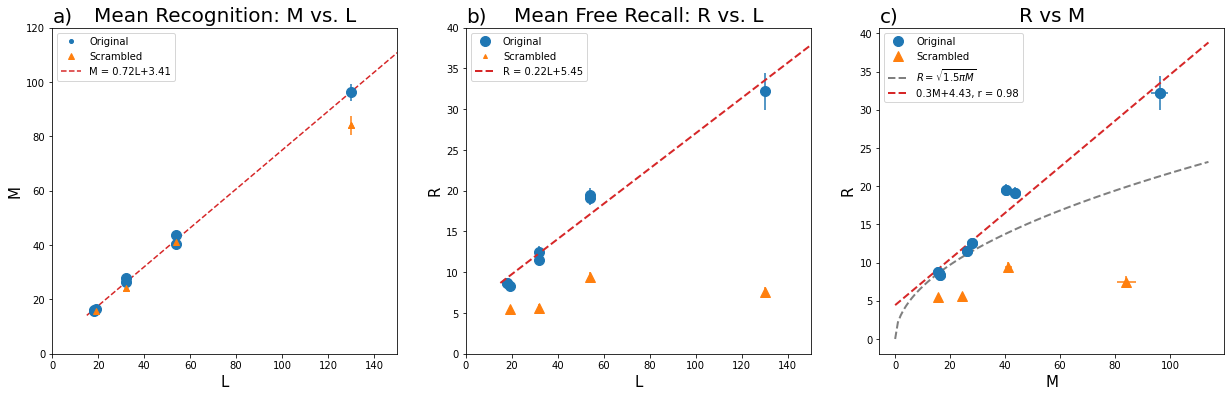

In [63]:

M_min = int(min(mt))
L_max= 2*int(max(lt))

ll = np.array([x for x in range(M_min,L_max)])




M_min = 0*int(min(mt))
M_max= int(1.2*max(mt))

m = np.array([x for x in range(M_min,M_max)])



fig, ax = plt.subplots(1,3,figsize=(21,6))#

#fig, ax = plt.subplot_mosaic([['a)', 'b)','c)']],
 #                             layout='constrained',figsize = (15,5))


ax[0].plot(lt, mt, 'o',markersize = 4,label='Original',color='tab:blue')
ax[0].errorbar(lt, mt, yerr=mt_error,fmt='o',markersize = 10,color = 'tab:blue')


ax[0].plot(lt_sc, mt_sc, '^',label='Scrambled',color='tab:orange')
ax[0].errorbar(lt_sc, mt_sc, yerr = mt_error_sc,fmt='^',markersize = 6,color = 'tab:orange')

#ax[0].plot(ll,(aM)*ll,'--',color = 'tab:red',label='M = '+str(np.round(aM[0],2))+'L, r = ' + str(np.round(r_m,3)))
ax[0].plot(ll,(ml_regress.slope.item())*ll+ml_regress.intercept.item(),'--',color = 'tab:red',label='M = '+str(ml_slope)+'L+'+str(ml_intercept))




ax[0].set_xlim([0, 150])
ax[0].set_ylim([0, 120])
ax[0].legend()
ax[0].set_title('Mean Recognition: M vs. L',fontsize=20)
ax[0].set_title('a)',  loc='left', fontsize=20)
ax[0].set_ylabel('M',fontsize = 15)
ax[0].set_xlabel('L',fontsize = 15)




ax[1].plot(lt, rt, 'o',markersize = 10,label='Original',color='tab:blue')
ax[1].errorbar(lt, rt, yerr=rt_error,markersize= 4,fmt='o',color='tab:blue')

ax[1].plot(lt_sc, rt_sc, '^',markersize = 4,label='Scrambled',color='tab:orange')
ax[1].errorbar(lt_sc, rt_sc, yerr = rt_error_sc,fmt='^',markersize = 10,color = 'tab:orange')
ax[1].plot(ll,(rl_regress.slope.item())*ll+rl_regress.intercept.item(),'--',color = 'tab:red',
           label='R = '+str(rl_slope)+'L+'+str(rl_intercept), linewidth = 2 )

#, r = ' + str(np.round(rl_regress.rvalue,3))

ax[1].set_xlim([0, 150])
ax[1].set_ylim([0, 40])
ax[1].legend()
ax[1].set_title('Mean Free Recall: R vs. L',fontsize=20)
ax[1].set_title('b)',  loc='left', fontsize=20)
ax[1].set_ylabel('R',fontsize=15)
ax[1].set_xlabel('L',fontsize=15)





ax[2].plot(mt, rt, 'o',markersize = 10, color ='tab:blue', label = 'Original')  #,label='R vs. M'
ax[2].errorbar(mt,rt,xerr = mt_error,yerr = rt_error,fmt = 'o',markersize = 10,color= 'tab:blue') #fmt='o',markersize = 4,alpha = 1.,

ax[2].plot(mt_sc, rt_sc, '^',markersize = 10, color = 'tab:orange',label = 'Scrambled')  #,label='R vs. M'

#ax[2].scatter(mt_sc, rt_sc, s=30,alpha=1, edgecolors="k",color = 'orange',label = 'Scrambled')  #,label='R vs. M'
ax[2].errorbar(mt_sc, rt_sc, xerr = mt_error_sc,yerr = rt_error_sc,fmt = '^',color = 'tab:orange')  #,label='R vs. M'


ax[2].plot(m,np.sqrt(3*np.pi/2)*np.sqrt(m),'--',color = 'tab:gray',label='$R = \sqrt{1.5 \pi M}$', linewidth = 2 )
#ax[2].plot(m,0.4096085405487828*m + 1.7540804817166027,'--',label = 'R = M',color = 'tab:red')
ax[2].plot(m,rm_slope*m +rm_intercept,'--',color = 'tab:red',
           label = str(np.round(rm_slope,2))+'M+'+str(np.round(rm_intercept,2)) + ', r = '+str(np.round(rm_rvalue,2)) ,
               linewidth = 2    )

#ax[2].plot(m,0.29*m +4.838,'-',color = 'tab:red',label = str(np.round(rm_slope,2))+'M+'+str(np.round(rm_intercept,2)))



#ax[2].set_xlim([0, 120])
#ax[2].set_ylim([0, 40])
ax[2].legend()
ax[2].set_title('R vs M',fontsize = 20)
ax[2].set_title('c)',  loc='left', fontsize=20)
ax[2].set_ylabel('R',fontsize = 15)
ax[2].set_xlabel('M',fontsize = 15)



plt.savefig('scaling-plots.png')

plt.show()
